In [1]:
import cartopy
import matplotlib.pyplot as plt
import numpy
%matplotlib inline
import topo_builder

In [2]:
# NeverWorld2 domain
NW2_lonW, NW2_lonE = 0, 80
NW2_latS, NW2_latN = -70, 70

D0 = 4000 # Nominal depth (m)
cd = 500 # Depth of coastal shelf (m)
drake = 2500 # Depth of Drake sill (m)
cw = 5 # Width of coastal shelf (degrees)

# Logical domain (grid points)
nj, ni = 140, 80

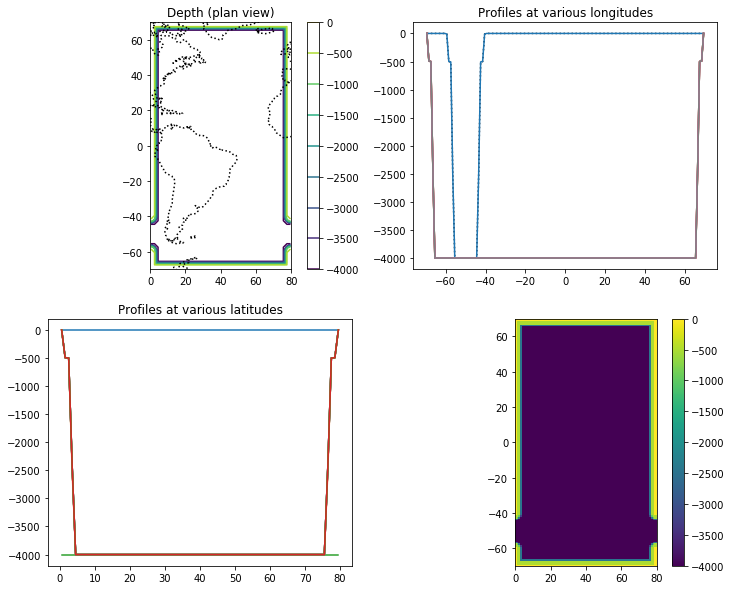

In [3]:
# Simple "Atlantic" box with re-entrant Drake passage

T = topo_builder.topo(nj, ni, dlon=NW2_lonE, dlat=NW2_latN-NW2_latS, lat0=NW2_latS, D=D0)
T.add_NS_coast(NW2_lonW, -40, 90, cw, cd)
T.add_NS_coast(NW2_lonE, -40, 90, cw, cd)
T.add_NS_coast(NW2_lonW, -90, -60, cw, cd)
T.add_NS_coast(NW2_lonE, -90, -60, cw, cd)
T.add_EW_coast(-360, 360, NW2_latS, cw, cd)
T.add_EW_coast(-360, 360, NW2_latN, cw, cd)

fig = plt.figure(figsize=(12,10))
T.plot(fig, Atlantic_lon_offset=-84)

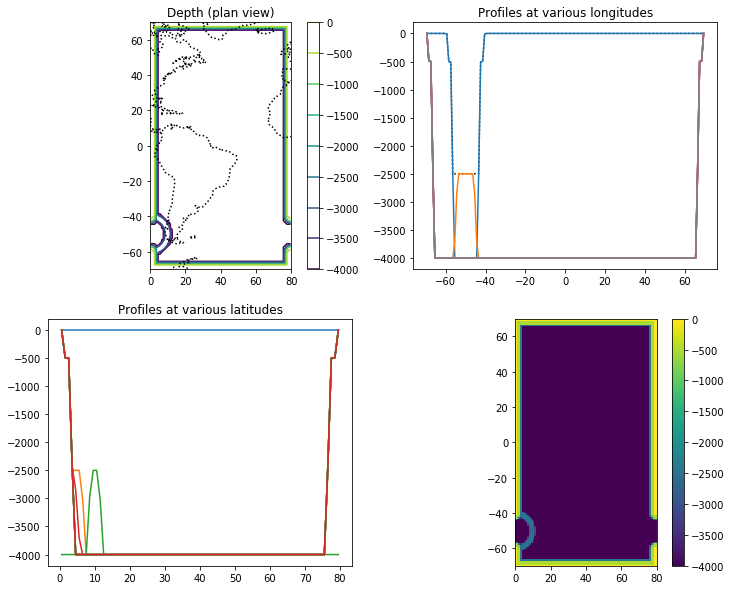

In [4]:
# Add a sill to Drake passage
T.add_circular_ridge(NW2_lonW, -50, 10, 2, drake) # Drake sill

fig = plt.figure(figsize=(12,10))
T.plot(fig, Atlantic_lon_offset=-84)

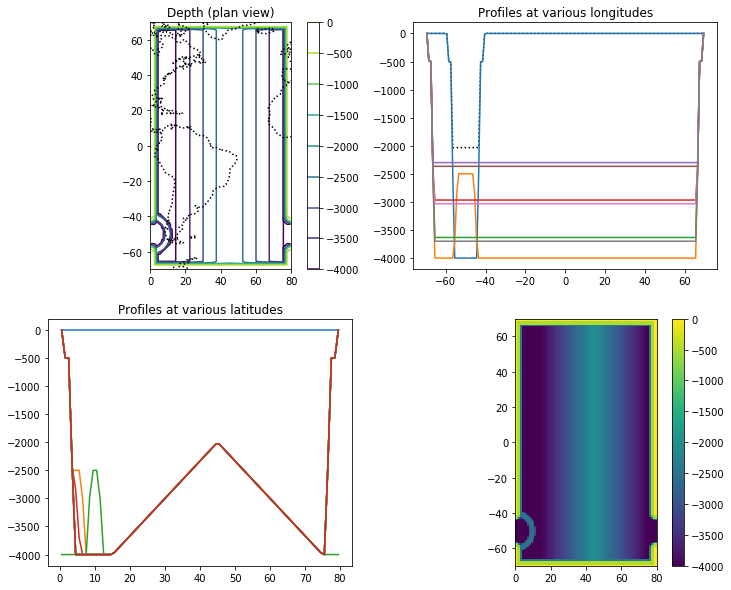

In [5]:
# Add a "Mid-Atlantic" ridge
T.add_NS_ridge(45, -90, 90, 30, D0/2) # Mid-Atlantic ridge?

fig = plt.figure(figsize=(12,10))
T.plot(fig, Atlantic_lon_offset=-84)

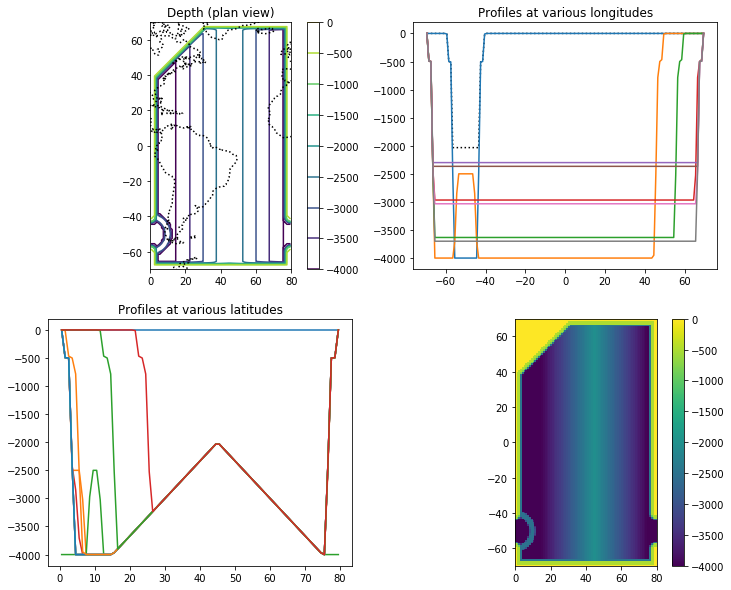

In [6]:
# Add a "New England" coastline
T.add_angled_coast(-40, 40, cw, cd) # New England

fig = plt.figure(figsize=(12,10))
T.plot(fig, Atlantic_lon_offset=-84)